In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
letters_shapes = [['111111',
          '001100',
          '001100',
          '001100',
          '001100',
          '001100'],
         ['100001',
          '010010',
          '001100',
          '001100',
          '010010',
          '100001'],
         ['001100',
          '010010',
          '100001',
          '100001',
          '010010',
          '001100'],
         ['111111',
          '100001',
          '100001',
          '100001',
          '100001',
          '111111'],
         ['001100',
          '001100',
          '110011',
          '110011',
          '001100',
          '001100']]

In [3]:
shapes = []
for l in letters_shapes:
    l_list = []
    for str_l in l:
        str_list = list(map(int, list(str_l)))
        l_list += str_list
    shapes += [l_list]

shapes = np.array(shapes)
print(shapes.shape)

(5, 36)


In [4]:
def plot_images(images):
    shape = int(np.sqrt(images.shape[1]))
    fig, ax1 = plt.subplots(1, len(images), figsize=(3, 3), sharex = True, sharey = True)
    for num, im in enumerate(images):
        ax1[num].imshow(im.reshape((shape, shape)), cmap = 'gray')
    
    plt.show()

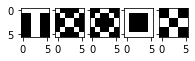

In [5]:
plot_images(shapes)

In [6]:
def make_noise(images, noise_percent):
    size = images.shape[1]
    a = np.arange(size)
    images_new = []
    for image in images:
        np.random.shuffle(a)
        randoms = a[:int(size*noise_percent/100)]
        image = np.array([not(i) if pos in randoms else i for pos, i in enumerate(image)])
        images_new += [image]
    return np.array(images_new)

In [7]:
class Activation(object):

    """
    Interface for activation functions (non-linearities).
    In all implementations, the state attribute must contain the result, i.e. the output of forward (it will be tested).
    """

    def __init__(self):
        self.state = None
    def __call__(self, x):
        return self.forward(x)
    def forward(self, x):
        raise NotImplementedError
    def derivative(self):
        raise NotImplementedError

class Identity(Activation):

    """
    Identity function (already implemented).
    """
    
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        self.state = x
        return x
    def derivative(self):
        return 1.0

class ReLU(Activation):

    """
    ReLU non-linearity
    """

    def __init__(self):
        super(ReLU, self).__init__()
    def forward(self, x):
        self.X = x
        self.state = np.maximum(0, x)
        return self.state
    def derivative(self):
        return np.where(self.X <= 0, 0., 1.)

class Criterion(object):

    """
    Interface for loss functions.
    """

    def __init__(self):
        self.logits = None
        self.labels = None
        self.loss = None
    def __call__(self, x, y):
        return self.forward(x, y)
    def forward(self, x, y):
        raise NotImplementedError
    def derivative(self):
        raise NotImplementedError


class SoftmaxCrossEntropy(Criterion):

    """
    Softmax loss
    """

    def __init__(self):
        super(SoftmaxCrossEntropy, self).__init__()
        self.sm = None
        
    def forward(self, x, y):
        self.logits = x
        self.labels = y
        # one-hot Y into regular class number
        class_num = y.argmax(axis=1)
        examples = class_num.shape[0]
        # softmax
        e = np.exp(x - np.max(x))  # LogExpTrick
        self.sm = e / np.sum(e, axis=1, keepdims=True)
        # cross entropy
        entropy = -np.log(self.sm[range(examples), class_num])
        return entropy
    
    def derivative(self):
        return self.sm - self.labels

In [13]:
class Network(object):

    """
    sdssdvfv
    """

    def __init__(self, input_size, output_size, activations, weight_init_fn, criterion, lr, rbf_samples):

        self.train_mode = True
        self.input_size = input_size
        self.output_size = output_size
        self.activation = activations
        self.criterion = criterion
        self.lr = lr
        self.rbf_samples = rbf_samples
        # <---------------------

        layer_sizes = (input_size, output_size)

        self.W = weight_init_fn(output_size, output_size)
        self.dW = np.zeros_like(self.W)
        
        self.sigma2 = []
        for i in range(self.rbf_samples.shape[0]):
            dist = 100000
            for ii in range(self.rbf_samples.shape[0]):
                if i==ii:
                    continue
                d = np.sum((self.rbf_samples[i] - self.rbf_samples[ii])**2)/4
                if dist > d:
                    dist = d
            self.sigma2.append(dist) 
        self.sigma2 = np.array(self.sigma2)

    def forward(self, x):
        
        self.x = x
        dist = np.array([self.x - sample for sample in self.rbf_samples]) ** 2
        self.rbf = np.exp(-np.sum(dist, axis=2) / self.sigma2[:,None])
        
        self.y = np.dot(self.rbf.T, self.W) 

        return self.y

    def zero_grads(self):
            self.activation.state = None
        

    def step(self):
        
        if self.train_mode:
        # update weight
            self.W -= self.lr * self.dW

    def backward(self, labels):
        
        num_samples = self.x.shape[0]
        predictions = self.y

        # calculate criterion to get divergence (diff with actual labels)
        self.loss = self.criterion(predictions, labels)
        dz = self.criterion.derivative()
        self.dW = np.dot(self.rbf, dz) / num_samples

        return 

    def __call__(self, x):
        return self.forward(x)

    def train(self):
        self.train_mode = True

    def evaluate(self):
        self.train_mode = False


In [9]:
def random_normal_weight_init(d0, d1):
    return np.random.randn(d0, d1)

def constant_weight_init(d0, d1):
    return np.full(shape=(d0, d1), fill_value=0.15)

In [10]:
def get_test_stats(mlp, test_dst):
    mlp.evaluate()
    test_x, test_y = test_dst
    objects_num = len(np.unique(test_y))
    test_y_onehot = np.eye(objects_num)[test_y]

    scores = mlp.forward(test_x)
    mlp.backward(test_y_onehot)

    test_similarity = scores
    test_loss = mlp.loss.mean()
    test_error = np.sum(test_y != np.argmax(scores, axis=1))/ len(test_x)
    return (test_similarity, test_loss, test_error)

In [11]:
def get_training_stats(mlp, train_dset, val_dset, batch_size, nepochs):

    trainx, trainy = train_dset
    valx, valy = val_dset
    objects_num = len(np.unique(trainy))
    objects_ls = np.arange(len(trainx))

    best_validation_loss = 3
    best_validation_error = 1
    best_epoch = 0
    best_weights = mlp.W
    
    training_losses = []
    training_errors = []
    validation_similarities = []
    validation_losses = []
    validation_errors = []

    # Setup ...
    for e in range(nepochs):

        # Per epoch setup ...
        training_loss = validation_loss = 0
        training_error = validation_error = 0
        validation_similarity = []

        mlp.train()
        np.random.shuffle(objects_ls)
        trainx, trainy = trainx[objects_ls], trainy[objects_ls]
        
        for txb in range(0, len(trainx), batch_size):

            train_x, train_y = trainx[txb: txb + batch_size], trainy[txb: txb + batch_size]
            train_y_onehot = np.eye(objects_num)[train_y]

            mlp.zero_grads()
            scores = mlp.forward(train_x)
            mlp.backward(train_y_onehot)

            training_loss += mlp.loss.mean()
            training_error += np.sum(train_y != np.argmax(scores, axis=1))

            # SGD
            mlp.step()

        training_losses.append(training_loss * batch_size / len(trainx))
        training_errors.append(training_error / len(trainx))

        # Validate
        mlp.evaluate()

        val_x, val_y = valx, valy
        val_y_onehot = np.eye(objects_num)[val_y]

        #mlp.zero_grads()
        scores = mlp.forward(val_x)
        mlp.backward(val_y_onehot)

        validation_loss = mlp.loss.mean()
        validation_error = np.sum(val_y != np.argmax(scores, axis=1)) / len(valy)
        if (validation_error<best_validation_error) & (validation_loss<best_validation_loss):
            best_validation_error = validation_error
            best_validation_loss = validation_loss
            best_epoch = e
            best_weights = mlp.W

        validation_similarities.append([scores])
        validation_losses.append(validation_loss)
        validation_errors.append(validation_error)

    return (training_losses, training_errors, validation_similarities, validation_losses, validation_errors, \
            best_validation_error, best_validation_loss, best_epoch, best_weights)


In [14]:
mlp = Network(input_size = shapes.shape[1], \
          output_size = shapes.shape[0], \
          activations = ReLU(), \
          weight_init_fn = random_normal_weight_init, \
          criterion = SoftmaxCrossEntropy(), \
          lr=0.2, \
          rbf_samples = shapes)

In [15]:
batch_size = 4
n_epochs = 15
train_size = 15
train_shapes = make_noise(np.repeat(shapes, train_size, axis=0), 3)
train_answers = np.repeat([i for i in range(shapes.shape[0])], train_size)
train_shapes = [train_shapes, train_answers]
val_size = 3
val_shapes = make_noise(np.repeat(shapes, val_size, axis=0), 6)
val_answers = np.repeat([i for i in range(shapes.shape[0])], val_size)
val_shapes = [val_shapes, val_answers]
train_loss, train_err, val_sim, val_loss, val_err, best_err, best_loss, best_epoch, best_weights = get_training_stats(mlp, train_shapes, val_shapes,batch_size, n_epochs)

The best error  0.0
The best loss  0.6842228459796225
The best epoch  6


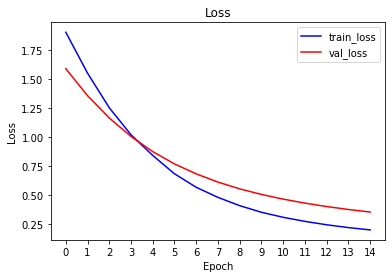

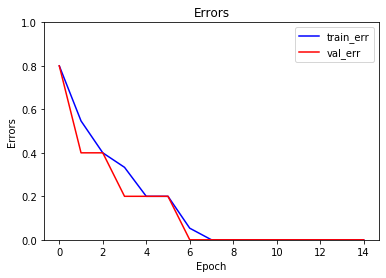

In [16]:
print("The best error ", best_err)
print("The best loss ", best_loss)
print("The best epoch ", best_epoch)
epochs = [i for i in range(n_epochs)]
plt.plot(epochs, train_loss, c = 'b', label = 'train_loss')
plt.plot(epochs, val_loss, c = 'r', label = 'val_loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.xticks(epochs)
plt.show()

fig, ax = plt.subplots()
ax.plot(epochs, train_err, c = 'b', label = 'train_err')
ax.plot(epochs, val_err, c = 'r', label = 'val_err')
ax.set_title('Errors')
ax.set_xlabel('Epoch')
ax.set_ylabel('Errors')
ax.legend(loc='upper right')
ax.set_ylim(0, 1)
plt.show()

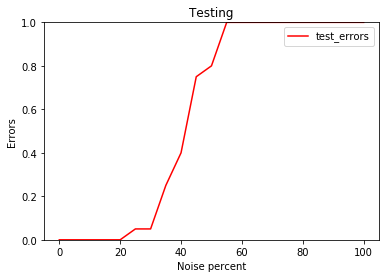

In [18]:
test_size = 4 
mlp.W = best_weights
noise_percent = np.linspace(0, 100, num=21, dtype = int)
test_shapes = np.repeat(shapes, test_size, axis=0)
test_answers = np.repeat([i for i in range(shapes.shape[0])], test_size) 

test_similarities = []
test_losses = []
test_errors = []
for noise in noise_percent:
    noise_test_shapes = make_noise(test_shapes, noise)
    test_dst = [noise_test_shapes, test_answers]
    test_similarity, test_loss, test_error = get_test_stats(mlp, test_dst)
    test_similarities.append([test_similarity])
    test_losses.append([test_loss])
    test_errors.append([test_error])

fig, ax = plt.subplots()
#plt.plot(noise_percent, test_losses, c = 'b', label = 'test_losses')
ax.plot(noise_percent, test_errors, c = 'r', label = 'test_errors')
ax.set_title('Testing')
ax.set_xlabel('Noise percent')
ax.set_ylabel('Errors')
ax.legend(loc='upper right')
ax.set_ylim(0, 1)
plt.show()